In [14]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as T

from torch.utils.data import DataLoader, ConcatDataset
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR
import numpy as np

from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment 

## Dataset

In [15]:
mnist_transforms = T.Compose(
    [
        T.Resize((28, 28)),
        T.ToTensor(),
    ]
)

train_dataset = MNIST('mnist', train=True, transform=mnist_transforms, download=True)
valid_dataset = MNIST('mnist', train=False, transform=mnist_transforms, download=True)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=True)

## Prepare

In [16]:
# %debug
def train(
    model, optimizer, loss_fn, device
):
    model.train()
    model.to(device)

    if isinstance(model, DEC):
        if not model.initialized:
            xs = []
            ys = []
            
            static_loader = DataLoader(
                train_dataset,
                batch_size=256,
                pin_memory=False,
                shuffle=False,
            )

            for x, y in tqdm(static_loader, desc='Initialization of cluster centers'):
                x, y = x.to(device), y.to(device)
                x = x.reshape(-1, 28*28)
                xs.append(model.encoder(x).detach().cpu())
                ys.append(y)

            xs = torch.cat(xs)
            ys = torch.cat(ys)

            with torch.no_grad():
                model.kmeans.fit(xs)

                model.state_dict()["assignment.centroids"].copy_(
                    torch.tensor(model.kmeans.cluster_centers_)
                )

                model.init_acc = cluster_acc(ys.cpu().numpy(), model.kmeans.labels_)
                print('Initial cluster accuracy:', model.init_acc)
                
                time.sleep(1)

            model.y_pred_previous_initiialized = False # necessary for delta initialization 
                    
            model.initialized = True
            print('Centroids weights were initialized.')

    train_loss = 0
    rec_loss, cl_loss = 0, 0
    ys = []
    outputs = []
    counter = 0

    for x, y in tqdm(train_loader, desc='Train'):
        
        x, y = x.to(device), y.to(device)
        x = x.reshape(-1, 28*28)

        optimizer.zero_grad()

        if isinstance(model, DEC):
        
            if type(model) == DEC:
                q = model(x)
                p = model.get_target_distribution(q).detach()
                
                loss = loss_fn(q.log(), p)
                
            elif type(model) == IDEC:
                
                q, output = model(x)
                p = model.get_target_distribution(q).detach()

                loss = loss_fn(
                    q.log(), p,
                    output, x
                )

                rec_loss += loss_fn.rec_loss
                cl_loss += loss_fn.cl_loss

            ys.append(y)
            outputs.append(q.cpu().detach().argmax(1)) 

        elif isinstance(model, StackedAutoEncoder):
            output = model(x)
            loss = loss_fn(output, x)
        
        else:
            raise TypeError("Received model type is not supported. Use StackedAutoEncoder, StackedDenoisingAutoEncoder, DEC or IDEC")
        
        train_loss += loss.item()
        
    
        loss.backward()
        optimizer.step(closure=None)
        

    train_loss /= len(train_loader)


    if isinstance(model, DEC):
        
        y = torch.cat(ys).cpu().numpy()
        y_pred = torch.cat(outputs).numpy()
        
        if type(model) == DEC:
            return (
                train_loss, # float
                y, 
                y_pred,
            )
        if type(model) == IDEC:
            rec_loss /= len(train_loader)
            cl_loss /= len(train_loader)
            
            train_loss = {
                'total': train_loss,
                'rec' : rec_loss.detach().cpu().numpy(),
                'clust' : cl_loss.detach().cpu().numpy(),
            }
            return (
                train_loss, # dict
                y, 
                y_pred,
            )
    elif isinstance(model, StackedAutoEncoder):
        return train_loss


In [17]:
@torch.inference_mode()
def evaluate(
    model, loader, loss_fn, device
):
    model.eval()

    eval_loss = 0

    outputs = []
    ys = []

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)
        x = x.reshape(-1, 28*28)

        if isinstance(model, DEC):
            if type(model) == DEC:

                q = model(x)
                p = model.get_target_distribution(q).detach()
                
                loss = loss_fn(q.log(), p)
                
            elif type(model) == IDEC:
                q, output = model(x)
                p = model.get_target_distribution(q).detach()
                
                loss = loss_fn(
                    q.log(), p,
                    output, x
                )

            ys.append(y)
            outputs.append(q.cpu().detach().argmax(1))

        elif isinstance(model, StackedAutoEncoder):
            output = model(x)
            loss = loss_fn(output, x)

        else:
            raise TypeError("Received model type is not supported. Use StackedAutoEncoder, StackedDenoisingAutoEncoder, DEC or IDEC")

        eval_loss += loss.item()

    eval_loss /= len(loader)


    if isinstance(model, DEC):
        with torch.no_grad():
            y = torch.cat(ys).cpu().numpy()
            y_pred = torch.cat(outputs).numpy()
            
        return (
            eval_loss,
            y,
            y_pred
        )
    elif isinstance(model, StackedAutoEncoder):
        return eval_loss
        

In [18]:
from typing import List

def plot_stats(
    train_loss: List[float],
    valid_loss: List[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()
    
    plt.show()


def plot_stats_dec(
    train_loss: List[float],
    valid_loss: List[float],

    train_acc: List[float],
    train_nmi: List[float],
    train_ari: List[float],
    val_acc: List[float],
    val_nmi: List[float],
    val_ari: List[float],

    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + " loss")

    plt.plot(train_loss, label="Train loss")
    plt.plot(valid_loss, label="Valid loss")
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + " cluster accuracy, normalized mutual info score, adjusted random info score")

    plt.plot(train_acc, label="Train acc", linewidth=1.5)
    plt.plot(train_nmi, label="Train nmi", linestyle='dashdot')
    plt.plot(train_ari, label="Train ari", linestyle='dashed')

    plt.plot(val_acc, label="Valid acc", linewidth=1.5)
    plt.plot(val_nmi, label="Valid nmi", linestyle='dashdot')
    plt.plot(val_ari, label="Valid ari", linestyle='dashed')

    plt.legend()
    plt.grid()

    plt.show()

def plot_stats_idec(
    train_loss: List[float],
    valid_loss: List[float],
    
    train_rec_loss: List[float],
    
    train_cl_loss: List[float],

    train_acc: List[float],
    train_nmi: List[float],
    train_ari: List[float],
    val_acc: List[float],
    val_nmi: List[float],
    val_ari: List[float],

    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + " loss")

    plt.plot(train_loss, label="Train loss")
    plt.plot(valid_loss, label="Valid loss")
        
    plt.plot(train_rec_loss, label="Train Reconstruct. loss",linestyle='dashdot')
    plt.plot(train_cl_loss, label="Train Clustering loss",linestyle='dashed')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + " cluster accuracy, normalized mutual info score, adjusted random info score")

    plt.plot(train_acc, label="Train acc", linewidth=2)
    plt.plot(train_nmi, label="Train nmi", linestyle='dashdot')
    plt.plot(train_ari, label="Train ari", linestyle='dashed')

    plt.plot(val_acc, label="Valid acc", linewidth=2)
    plt.plot(val_nmi, label="Valid nmi", linestyle='dashdot')
    plt.plot(val_ari, label="Valid ari", linestyle='dashed')

    plt.legend()
    plt.grid()

    plt.show()



In [19]:
# %debug
def whole_train_valid_cycle(
    model, scheduler, optimizer, loss_fn, device, title,
    num_epochs:int = 100, 
    patience_threshold = None,
    delta_threshold:int = None, 
    save_best_params_as:str = None
):
    train_loss_history, valid_loss_history = [], []
    
    best_valid_loss = np.inf
    best_val_acc = 0
    
    patience =0

    train_acc_history, train_nmi_history, train_ari_history = [], [], []
    val_acc_history, val_nmi_history, val_ari_history = [], [], []
    
    if type(model) == IDEC:
        train_rec_loss_history, train_cl_loss_history = [], []
        valid_rec_loss_history, valid_cl_loss_history = [], []

    for epoch in range(num_epochs):

        if isinstance(model, DEC):

            train_loss, train_y, train_y_pred, = train(model, optimizer, loss_fn, device)

#             if not model.y_pred_previous_initiialized:
#                 train_y_pred_previous = np.copy(model.kmeans.labels_)
#                 model.y_pred_previous_initiialized = True
           

            # check delta threshold after train loop
#             delta = (train_y_pred != train_y_pred_previous).sum() / len(train_y_pred_previous)
#             if delta_threshold is not None and delta < delta_threshold:
#                 print(
#                     'Early stopping as current delta "%1.5f" less than "%1.5f" delta threshold.'
#                     % (delta, delta_threshold)
#                 )
#                 break
#             if model.y_pred_previous_initiialized:
#                 train_y_pred_previous = np.copy(train_y_pred)
            
            # start evaluation loop
            valid_loss, val_targets, val_predicted = evaluate(model, valid_loader, loss_fn, device)
            
            if type(model) == IDEC:

                train_rec_loss, train_cl_loss = train_loss['rec'], train_loss['clust']
                train_loss = train_loss['total']
                
#                 val_rec_loss, val_cl_loss = val_loss['rec'], val_loss['clust']
#                 val_loss = val_loss['total']
                
                train_rec_loss_history.append(train_rec_loss)
                train_cl_loss_history.append(train_cl_loss)
                
#                 valid_rec_loss_history.append(val_rec_loss)
#                 valid_cl_loss_history.append(val_cl_loss)
                
    
            train_acc = cluster_acc(train_y, train_y_pred)
            train_nmi = normalized_mutual_info_score(train_y, train_y_pred)
            train_ari = adjusted_rand_score(train_y, train_y_pred)

            train_acc_history.append(train_acc)
            train_nmi_history.append(train_nmi)
            train_ari_history.append(train_ari)

            val_acc = cluster_acc(val_targets, val_predicted)
            val_nmi = normalized_mutual_info_score(val_targets, val_predicted)
            val_ari = adjusted_rand_score(val_targets, val_predicted)

            val_acc_history.append(val_acc)
            val_nmi_history.append(val_nmi)
            val_ari_history.append(val_ari)
        
 
        elif isinstance(model, StackedAutoEncoder):
            train_loss = train(model, optimizer, loss_fn, device)
            valid_loss = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        print('patience:',patience)
        if patience_threshold is not None and len(valid_loss_history)>1:
            if round(valid_loss_history[-2], 5) == round(valid_loss, 5):
                patience += 1
            else:
                patience = 0

            
            if patience == patience_threshold:
                print('Training stopped. Patience threshold was reached')
                break


        clear_output(wait=True)
        
        # visualize(model, next(iter(valid_loader))[0])

        if isinstance(model, DEC):
            if type(model) == DEC:
                plot_stats_dec(
                    train_loss_history, valid_loss_history, 
                    train_acc_history, train_nmi_history, train_ari_history,
                    val_acc_history, val_nmi_history, val_ari_history,
                    title,
                )
            if type(model) == IDEC:
                plot_stats_idec(
                    train_loss_history, valid_loss_history, 
                    train_rec_loss_history, 
                    train_cl_loss_history,
                    train_acc_history, train_nmi_history, train_ari_history,
                    val_acc_history, val_nmi_history, val_ari_history,
                    title,
                )

        elif isinstance(model, StackedAutoEncoder):

            plot_stats(
                train_loss_history, valid_loss_history,
                title
            )
            # scheduler only for autoencoder
            scheduler.step() if not scheduler == None else None


        if not save_best_params_as == None:
#             if isinstance(model, StackedAutoEncoder):
            if valid_loss < best_valid_loss: 
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), save_best_params_as)
                print(f"Model parameters saved to '{save_best_params_as}'")
#             if isinstance(model, DEC):
#                 if val_acc > best_val_acc: 
#                     best_val_acc = val_acc
#                     torch.save(model.state_dict(), save_best_params_as)
#                     print(f"Model parameters saved to '{save_best_params_as}'")
                    
        

            

## Net

In [20]:
#!g1.1
class Block(nn.Module):
    def __init__(
        self, 
        inp_dim: int, 
        out_dim: int,
        activation: nn.Module,
        dropout_value: float
    ):
        super().__init__()
        self.fc1 = nn.Linear(inp_dim, out_dim)
        self.act = activation()
        self.dropout = nn.Dropout(dropout_value)
 
    def forward(self, x):
        return self.dropout(
            self.act(self.fc1(x))
        )

class StackedAutoEncoder(nn.Module):
    def __init__(
        self, 
        dims:list, 
        activation:nn.Module = nn.ReLU,
        dropout_value:float = .0,
        base_block:nn.Module = Block,
    ):
        """
        Fully connected auto-encoder model, symmetric.
        Arguments:
            dims: list of number of units in each layer of encoder. dims[0] is input dims, dims[-1] is units in hidden layer.
                The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
            act: activation, not applied to Input, Hidden and Output layers
        return:
            Model of autoencoder
        """
        super().__init__()
        self.dims = dims
        self.inp_dim = dims[0]
        self.hid_dim = dims[-1]
        self.dropout_value = dropout_value
        self.activation = activation

        # encoder
        encoder_blocks = []
        encoder_blocks.extend([
            base_block(self.inp_dim, dims[1], nn.Identity, dropout_value),
            base_block(dims[1], dims[2], activation, dropout_value),
            base_block(dims[2], dims[3], activation, dropout_value),
            base_block(dims[3], self.hid_dim, nn.Identity, dropout_value),
        ])

        self.encoder = nn.Sequential(*encoder_blocks) 

        # decoder
        decoder_blocks = []
        decoder_blocks.extend([
            base_block(self.hid_dim, dims[3], activation, dropout_value),
            base_block(dims[3], dims[2], activation, dropout_value),
            base_block(dims[2], dims[1], activation, dropout_value),
            base_block(dims[1], self.inp_dim, nn.Identity, dropout_value), #nn.Identity f(x)==x
        ])
        
        self.decoder = nn.Sequential(*decoder_blocks)


    def set_dropout_value(self, value:float):
        self.dropout_value = value

        for i in range(len(self.encoder)):
            self.encoder[i].dropout.p = self.dropout_value
        for i in range(len(self.decoder)):
            self.decoder[i].dropout.p = self.dropout_value


    def forward(self, x):
        self.set_dropout_value(self.dropout_value) # inplace

        return self.decoder(self.encoder(x))



In [21]:
class DenoisingBlock(Block):
    def __init__(
        self, 
        inp_dim: int, 
        out_dim: int,
        activation: nn.Module,
        dropout_value: float
    ):
        super().__init__(inp_dim, out_dim, activation, dropout_value)
                
    def forward(self, x):
        if self.training:
            x = x + torch.randn_like(x) * 0.05

        return self.act(
            self.dropout(self.fc1(x))
        )


class StackedDenoisingAutoEncoder(StackedAutoEncoder):
    def __init__(
        self, 
        dims:list, 
        activation: nn.Module = nn.ReLU,
        dropout_value: float = .0,
        base_block: nn.Module = DenoisingBlock,
    ):
        super().__init__(dims, activation, dropout_value, base_block,)

    def forward(self, x):
        if self.training:
            x = torch.clip(x + torch.randn_like(x) * 0.1, min=0, max=1)

        return self.decoder(self.encoder(x))


In [22]:
from sklearn.cluster import KMeans

class ClusterAssignment(nn.Module):
    def __init__(
        self,
        num_cluster: int,
        hidden_dim: int,
        alpha: float = 1.0,
        centroids: torch.tensor = None,
    ):
        """ 
        student t-distribution, as same as used in t-SNE algorithm.
                    q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            num_cluster: 
            hidden_dim: 
            alpha:
            centroids:
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        super().__init__()
        self.num_cluster = num_cluster
        self.hidden_dim = hidden_dim
        self.alpha = alpha
        self.centroids = centroids
        
        if centroids is None:
            centroids = torch.zeros(
                self.num_cluster, self.hidden_dim, dtype=torch.float
            )
            nn.init.xavier_uniform_(centroids)

        self.centroids = nn.Parameter(centroids)


    def forward(self, z):
        z, self.centroids = z.to(device), self.centroids.to(device)

        diff = torch.sum((z.unsqueeze(1) - self.centroids) ** 2, 2)
        numerator = 1.0 / (1.0 + (diff / self.alpha))
        power = (self.alpha + 1.0) / 2
        numerator = numerator ** power
        q = numerator / torch.sum(numerator, dim=1, keepdim=True)
        return q


class DEC(nn.Module):
    def __init__(
        self, 
        autoencoder: nn.Module,
        n_clusters: int = 10,
        alpha: float = 1.0,
        centroids = None,
    ):
        '''
        Deep Embedded Clustering
        '''
        super().__init__()
        self.encoder = autoencoder.encoder
        self.n_clusters = n_clusters
        self.hidden_dim = autoencoder.hid_dim
        self.alpha = alpha

        self.assignment = ClusterAssignment(
            n_clusters, autoencoder.hid_dim, alpha, centroids
        )
        self.kmeans = KMeans(n_clusters, n_init=20)
        self.initialized = False
        

    def forward(self, x):
        return self.assignment(self.encoder(x))

    def get_target_distribution(self, q):
        numerator = (q ** 2) / torch.sum(q, 0)
        p = (numerator.t() / torch.sum(numerator, 1)).t()
        return p


class IDEC(DEC):
    def __init__(
        self, 
        autoencoder: nn.Module,
        n_clusters: int = 10,
        alpha: float = 1.0,
    ):    
        super().__init__(
            autoencoder,
            n_clusters,
            alpha,
        ) 
        self.decoder = autoencoder.decoder
   
    
    def forward(self, x):
        return(
            self.assignment(self.encoder(x)),
            self.decoder(self.encoder(x))
        )
    

In [23]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    
    return w[row_ind, col_ind].sum() / y_pred.size
    

In [24]:
class IDEC_loss(nn.Module):
    def __init__(self, gamma=.1):
        super().__init__();
        self.gamma = gamma

    def forward(self, pred_cl, targ_cl, pred_rec, targ_rec, ):
        """
        See original paper for explanation
        """
        loss_cl = nn.KLDivLoss(reduction='batchmean')
        loss_rec = nn.MSELoss()
        self.cl_loss = self.gamma * loss_cl(pred_cl, targ_cl) #value
        self.rec_loss = loss_rec(pred_rec, targ_rec) #value
        
        return self.rec_loss + self.cl_loss
    

## Initialize

In [25]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

cuda:0
NVIDIA GeForce GTX 1060 with Max-Q Design


## Run Autoencoder

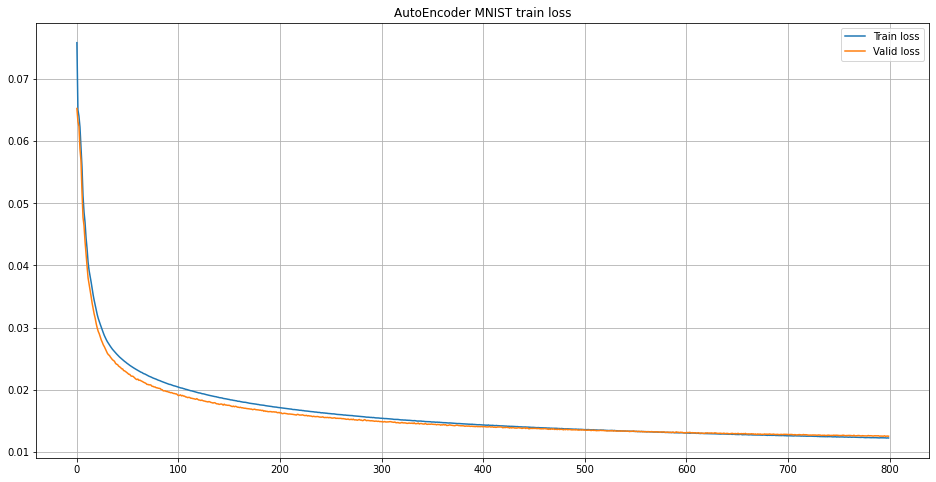

In [ ]:
loss_fn = nn.MSELoss()
model = StackedDenoisingAutoEncoder(dims=[784, 500, 500, 2000, 10], dropout_value=.002)

# optimizer = Adam(model.parameters(), lr=1e-3)
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=200, gamma=0.1) # 60~=20000/256


whole_train_valid_cycle(
    model, 
    None,
    optimizer,
    loss_fn,
    num_epochs = 800, 
    device = device,
    patience_threshold = 10,
    save_best_params_as = 'train-stdict-mnist_drop002.pt',
    title='AutoEncoder MNIST train'
)

In [ ]:
# model.load_state_dict(torch.load(r'pretrain-model-parameters4mnist.pt'))

<All keys matched successfully>

## Run DEC

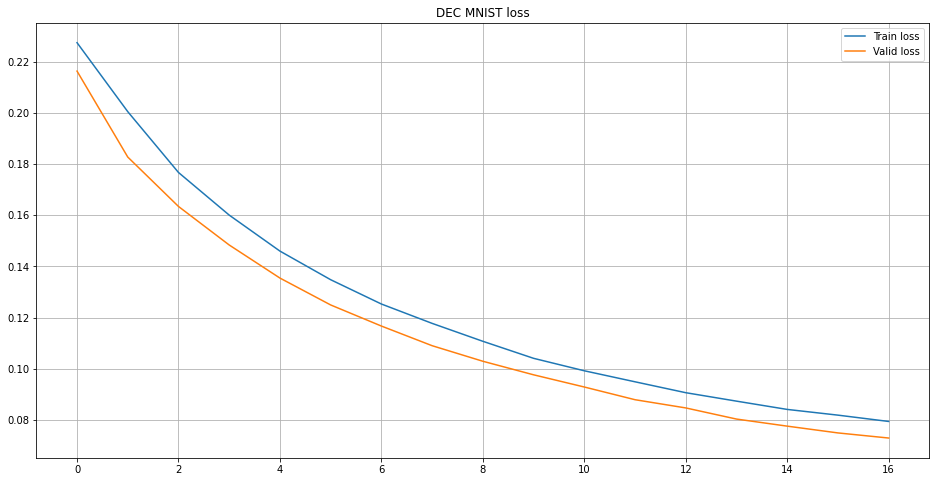

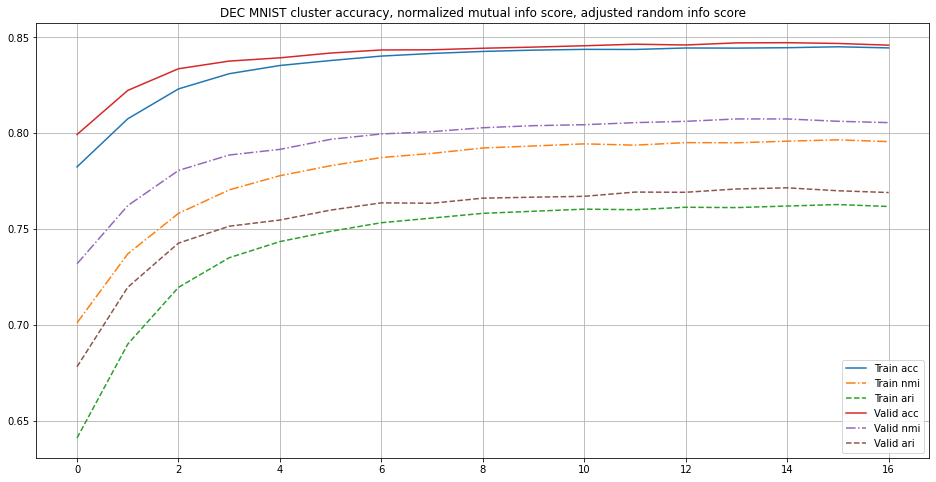

Model parameters saved to './working/dec_weights.pt'


Train:  34%|███▍      | 80/235 [00:02<00:05, 28.67it/s]


KeyboardInterrupt: 

In [ ]:
model = StackedAutoEncoder(dims=[784, 500, 500, 2000, 10], dropout_value=.0)

model.load_state_dict(torch.load('./input/ae-weights/train-stdict-mnist_drop002.pt'))


dec = DEC(autoencoder = model)
loss_fn = nn.KLDivLoss(reduction='batchmean')

# optimizer = Adam(dec.parameters(), lr=1e-4)
optimizer = SGD(dec.parameters(), lr=.01, momentum=0.9)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 50,
    patience_threshold = 10,
    save_best_params_as = './working/dec_weights.pt',
    device = device,
    title='DEC MNIST'
)


In [ ]:
print(
    dec.init_acc,
cluster_acc(
    train_dataset.targets.numpy(),
    dec(train_dataset.data.reshape(-1, 784).to(device, dtype=torch.float32)).argmax(1).detach().cpu().numpy()
)
)

0.7700333333333333 0.8500333333333333


## Run IDEC

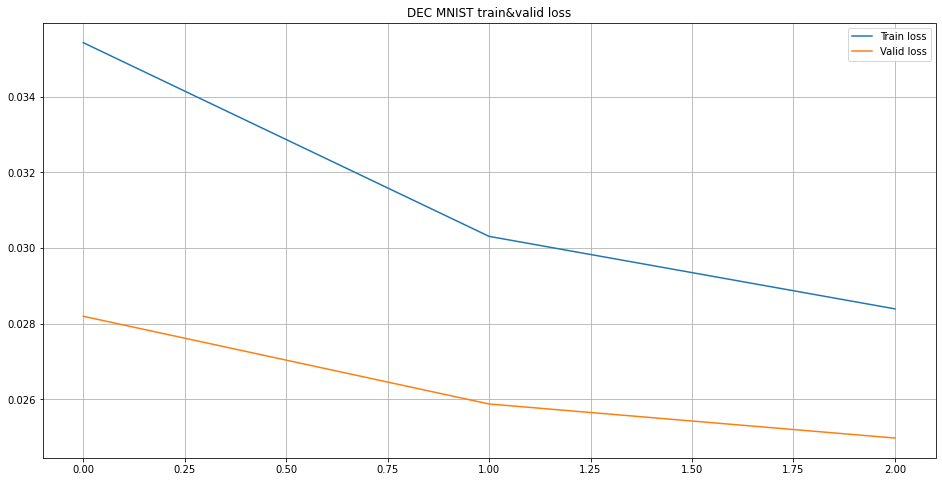

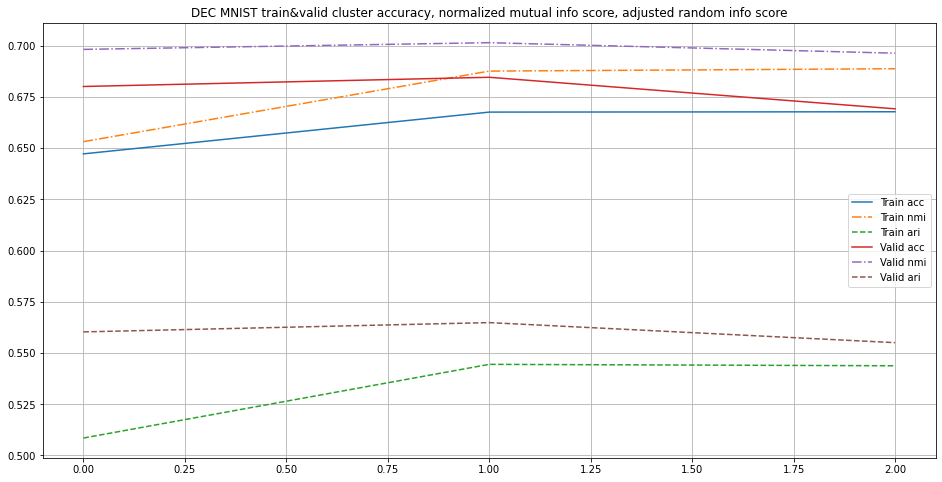

Train:   1%|          | 2/235 [00:00<00:14, 16.46it/s]


KeyboardInterrupt: 

In [16]:
model = StackedAutoEncoder(dims=[784, 500, 500, 2000, 10], dropout_value=.01)

model.load_state_dict(torch.load(r'best-model-parameters4mnist.pt'))

idec = IDEC(autoencoder=model)
loss_fn = IDEC_loss(gamma=.1)

optimizer = Adam(idec.parameters(), lr=1e-3,  betas = (.9, .999))
# optimizer = SGD(idec.parameters(), lr=0.01, momentum=0.9)

whole_train_valid_cycle(
    idec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 100,
    delta_threshold = .1,
    # save_best_params_as = 'idec_weights.pt',
    device=device,
    title='DEC MNIST train&valid'
)

In [ ]:
# torch.save(idec.state_dict(), 'idec_weights.pt')